## Project Overview & Class Distribution

This project aims to classify dental images into 7 distinct categories. Understanding the dataset balance is crucial for model training.

**Classes:**
- The dataset contains 7 classes (folders): CaS, CoS, Gum, MC, OC, OLP, OT.

In [1]:
import os
import time
import copy
import random
from torchvision import datasets
from typing import Optional, Callable, List, Dict, Any, Tuple
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

## Configuration

In [2]:
# Config
DATA_DIR = "/kaggle/input/teeth-classification-dataset/Teeth_Dataset"
TRAIN_DIR = os.path.join(DATA_DIR, 'Training')
VAL_DIR = os.path.join(DATA_DIR, 'Validation')
TEST_DIR = os.path.join(DATA_DIR, 'Testing')

BATCH_SIZE = 64
LEARNING_RATE = 1e-3
EPOCHS = 100
IMG_SIZE = 224
NUM_CLASSES = 7

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Class Distribution
**Class weights** will be used to handle the imbalance.

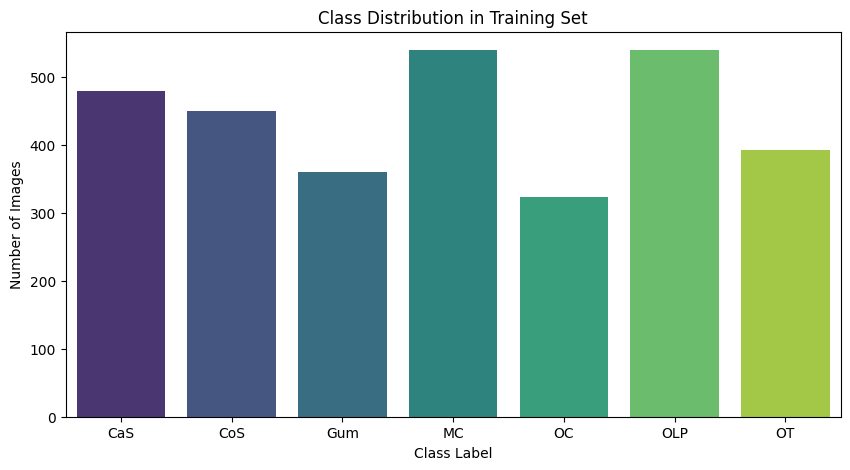

In [3]:
classes = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
train_counts = [len(os.listdir(os.path.join(TRAIN_DIR, cls))) for cls in classes]

df_dist = pd.DataFrame({'Class': classes, 'Count': train_counts})

plt.figure(figsize=(10, 5))
sns.barplot(x='Class', y='Count', data=df_dist, hue='Class', palette='viridis', legend=False)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.show()

## Visualizing the dataset

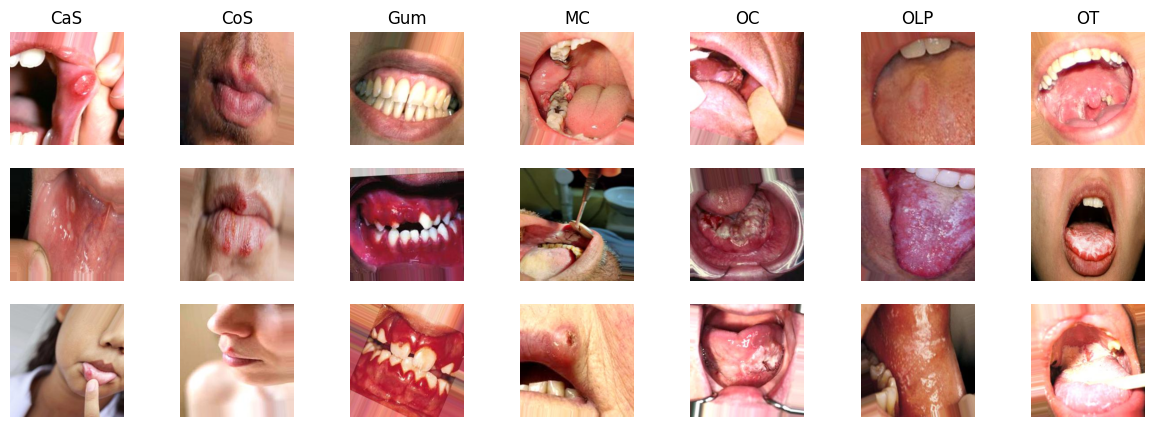

In [4]:
# Visualize different classes
rows = 3
plt.figure(figsize=(15, 5))
for i, cls in enumerate(classes):
    if os.path.isdir(os.path.join(TRAIN_DIR, cls)):
        for row in range(rows):
            img_name = random.choice(os.listdir(os.path.join(TRAIN_DIR, cls)))
            img_path = os.path.join(TRAIN_DIR, cls, img_name)
            img = Image.open(img_path)
            
            plt.subplot(rows, len(classes), row * len(classes) + i + 1)
            plt.imshow(img.resize((IMG_SIZE, IMG_SIZE)))
            if row == 0:
                plt.title(cls)
            plt.axis('off')
plt.show()

## Data Augmentation Visualization

Data Augmentation is applied to the training set to improve generalization. Additionally, a raw image is compared with its augmented version to verify the transformations.

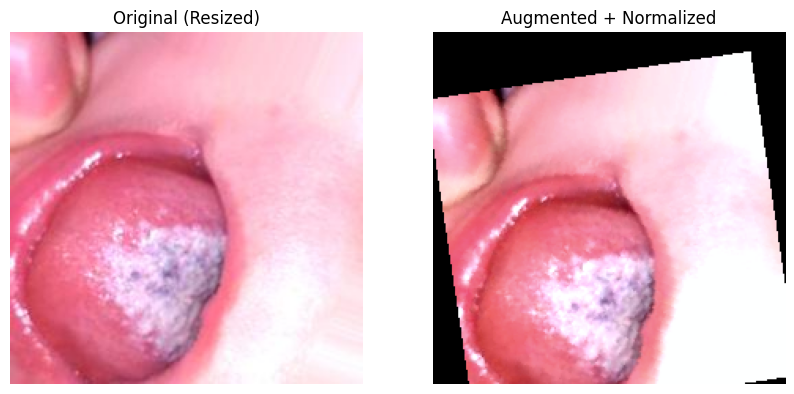

In [5]:
# Define Transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Visualization Helper
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)

# Pick random image to visualize
demo_class = random.choice(classes)
demo_img_name = random.choice(os.listdir(os.path.join(TRAIN_DIR, demo_class)))
demo_img_path = os.path.join(TRAIN_DIR, demo_class, demo_img_name)
original_img = Image.open(demo_img_path)

# Apply Transform
augmented_img = data_transforms['train'](original_img)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_img.resize((IMG_SIZE, IMG_SIZE)))
plt.title("Original (Resized)")
plt.axis('off')

plt.subplot(1, 2, 2)
imshow(augmented_img, title="Augmented + Normalized")
plt.axis('off')

plt.show()

## Data Loaders

In [6]:
class FilteredImageFolder(datasets.ImageFolder):
    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        loader: Callable[[str], Any] = datasets.folder.default_loader,
        is_valid_file: Optional[Callable[[str], bool]] = None,
        classes: Optional[List[str]] = None,
    ):
        self.filter_classes = classes
        super().__init__(root, transform, target_transform, loader, is_valid_file)

    def find_classes(self, directory: str) -> Tuple[List[str], Dict[str, int]]:
        if self.filter_classes:
            classes = sorted(self.filter_classes)
            class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
            return classes, class_to_idx
        else:
            return super().find_classes(directory)

# 1. Load Train Dataset
train_dataset = datasets.ImageFolder(TRAIN_DIR, data_transforms['train'])
class_names = train_dataset.classes
print(f"Train Classes: {class_names}")

# 2. Load Val and Test Datasets using FilteredImageFolder with the training classes
image_datasets = {
    'train': train_dataset,
    'val': FilteredImageFolder(VAL_DIR, data_transforms['val'], classes=class_names),
    'test': FilteredImageFolder(TEST_DIR, data_transforms['test'], classes=class_names)
}

num_workers = os.cpu_count()
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=(x=='train'), num_workers=num_workers)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
print(f"Dataset Sizes: {dataset_sizes}")

Train Classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Dataset Sizes: {'train': 3087, 'val': 1028, 'test': 1028}


## ConvNeXt Model Definition

In [7]:
class Permute(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.dims = dims

    def forward(self, x):
        return x.permute(self.dims)

def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()
    output = x.div(keep_prob) * random_tensor
    return output

class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

class ConvNeXtBlock(nn.Module):
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) 
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) 
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)), 
                                    requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)
        x = input + self.drop_path(x)
        return x

class ConvNeXt(nn.Module):
    def __init__(self, in_chans=3, num_classes=1000, 
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0., 
                 layer_scale_init_value=1e-6, head_init_scale=1.,
                 **kwargs):
        super().__init__()

        self.downsample_layers = nn.ModuleList() 
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            Permute([0, 2, 3, 1]),
            nn.LayerNorm(dims[0], eps=1e-6),
            Permute([0, 3, 1, 2])
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    Permute([0, 2, 3, 1]),
                    nn.LayerNorm(dims[i], eps=1e-6),
                    Permute([0, 3, 1, 2]),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() 
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] 
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[ConvNeXtBlock(dim=dims[i], drop_path=dp_rates[cur + j], 
                layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) 
        self.head = nn.Linear(dims[-1], num_classes)

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.normal_(m.weight, std=0.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1]))

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return F.log_softmax(x, dim=1) # Matching NLLLoss usage

model = ConvNeXt(num_classes=NUM_CLASSES).to(device)
print(model)

ConvNeXt(
  (downsample_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      (3): Permute()
    )
    (1): Sequential(
      (0): Permute()
      (1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      (2): Permute()
      (3): Conv2d(96, 192, kernel_size=(2, 2), stride=(2, 2))
    )
    (2): Sequential(
      (0): Permute()
      (1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (2): Permute()
      (3): Conv2d(192, 384, kernel_size=(2, 2), stride=(2, 2))
    )
    (3): Sequential(
      (0): Permute()
      (1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (2): Permute()
      (3): Conv2d(384, 768, kernel_size=(2, 2), stride=(2, 2))
    )
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): ConvNeXtBlock(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
   

## Training Setup
Using Class Weights, AdamW, Early Stopping, and Learning Rate Scheduler.

In [8]:
# Calculate Class Weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(image_datasets['train'].targets), y=image_datasets['train'].targets)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class Weights: {class_weights}")

# Optimizer, Loss, Scheduler
criterion = nn.NLLLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

Class Weights: tensor([0.9187, 0.9800, 1.2250, 0.8167, 1.3611, 0.8167, 1.1221],
       device='cuda:0')


## Training Loop

In [9]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    since = time.time()
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    torch.save(model.state_dict(), 'best_model.pth')
    best_acc = 0.0
    
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                
                # Step the scheduler
                scheduler.step(epoch_loss)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), 'best_model.pth')

                # Check early stopping
                early_stopping(epoch_loss)
                if early_stopping.early_stop:
                    print("Early stopping")
                    model.load_state_dict(best_model_wts)
                    return model, history
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS, patience=5)

Epoch 1/100
----------
train Loss: 2.2529 Acc: 0.1753
val Loss: 1.9241 Acc: 0.1673

Epoch 2/100
----------
train Loss: 1.9571 Acc: 0.1918
val Loss: 1.8877 Acc: 0.2014

Epoch 3/100
----------
train Loss: 1.9353 Acc: 0.1940
val Loss: 1.8443 Acc: 0.1946

Epoch 4/100
----------
train Loss: 1.8721 Acc: 0.2222
val Loss: 1.7864 Acc: 0.2977

Epoch 5/100
----------
train Loss: 1.8389 Acc: 0.2481
val Loss: 1.7349 Acc: 0.3016

Epoch 6/100
----------
train Loss: 1.7904 Acc: 0.2783
val Loss: 1.7973 Acc: 0.2461

Epoch 7/100
----------
train Loss: 1.7659 Acc: 0.2915
val Loss: 1.7645 Acc: 0.3035

Epoch 8/100
----------
train Loss: 1.7386 Acc: 0.3107
val Loss: 1.7020 Acc: 0.3434

Epoch 9/100
----------
train Loss: 1.6850 Acc: 0.3447
val Loss: 1.6880 Acc: 0.3677

Epoch 10/100
----------
train Loss: 1.6617 Acc: 0.3405
val Loss: 1.5689 Acc: 0.3930

Epoch 11/100
----------
train Loss: 1.5986 Acc: 0.3738
val Loss: 1.5221 Acc: 0.4241

Epoch 12/100
----------
train Loss: 1.5555 Acc: 0.3946
val Loss: 1.5142 Ac

## Visualization
Plotting Error vs Epochs and Accuracy.

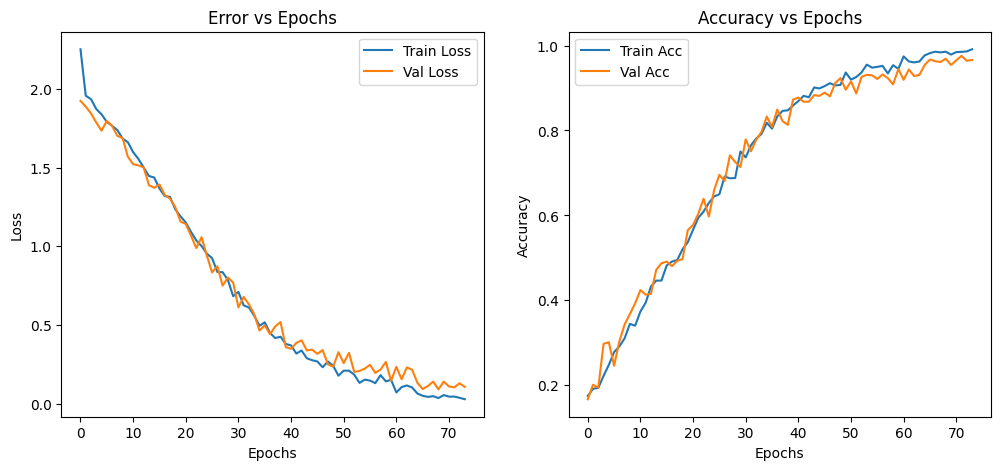

In [10]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Error vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluation (Test Set)

In [11]:
def evaluate_model(model, loader, criterion=None, device=None):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    num_samples = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            if criterion:
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                num_samples += inputs.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    avg_loss = running_loss / num_samples if criterion and num_samples > 0 else None
    return np.array(all_labels), np.array(all_preds), avg_loss

# Run evaluation with loss calculation
y_true, y_pred, test_loss = evaluate_model(model, dataloaders['test'], criterion, device)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {accuracy_score(y_true, y_pred):.4f}')

Test Loss: 0.0912
Test Accuracy: 0.9728


### Confusion Matrix

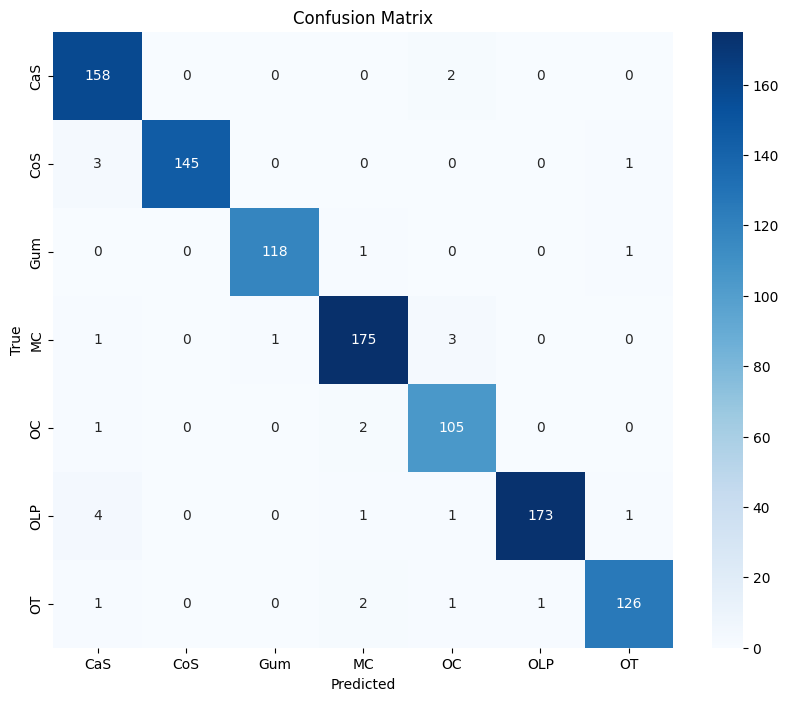

In [12]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Precision and Recall Table

In [13]:
report = classification_report(y_true, y_pred, labels=list(range(len(class_names))), target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("Classification Report:")
display(df_report)

Classification Report:


,precision,recall,f1-score,support
CaS,0.940476,0.987500,0.963415,160.000000
CoS,1.000000,0.973154,0.986395,149.000000
Gum,0.991597,0.983333,0.987448,120.000000
MC,0.966851,0.972222,0.969529,180.000000
OC,0.937500,0.972222,0.954545,108.000000
OLP,0.994253,0.961111,0.977401,180.000000
OT,0.976744,0.961832,0.969231,131.000000
accuracy,0.972763,0.972763,0.972763,0.972763
macro avg,0.972489,0.973054,0.972566,1028.000000
weighted avg,0.973414,0.972763,0.972880,1028.000000
